# Task 2: Graphs in 3D
## 2.1 Voxel format

#### 2.1.0 Install and import libraries

In [ ]:
!pip install torch-geometric -f https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
!pip install torch torchvision open3d

Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 104.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidg

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch_geometric
import matplotlib.pyplot as plt
import os
from glob import glob
import open3d as o3d

#### 2.1.1 Data exploration and random baseline

*a. Data exploration*

In [ ]:
from torch_geometric.datasets import ModelNet
import torch_geometric.transforms as T

train_dataset = ModelNet(
    root="ModelNet10",
    train=True,
    pre_transform=T.NormalizeScale()
)

test_dataset = ModelNet(
    root="ModelNet10",
    train=False,
    pre_transform=T.NormalizeScale()
)

Extracting ModelNet10/ModelNet10.zip
Processing...
Done!


In [ ]:
print(f'Training Dataset: {train_dataset}')
print(f'Number of shapes: {len(train_dataset)}')
print(f'Number of classes: {train_dataset.num_classes}')
print(f'First example: {train_dataset[0]}')
print(f'Average number of points: {train_dataset.pos.shape[0] / train_dataset.y.shape[0]}\n')

print(f'Test Dataset: {test_dataset}')
print(f'Number of shapes: {len(test_dataset)}')
print(f'Number of classes: {test_dataset.num_classes}')
print(f'First example: {test_dataset[0]}')
print(f'Average number of points: {test_dataset.pos.shape[0] / test_dataset.y.shape[0]}')

Training Dataset: ModelNet10(3991)
Number of shapes: 3991
Number of classes: 10
First example: Data(pos=[2128, 3], face=[3, 3260], y=[1])
Average number of points: 9897.486594838387

Test Dataset: ModelNet10(908)
Number of shapes: 908
Number of classes: 10
First example: Data(pos=[5452, 3], face=[3, 8516], y=[1])
Average number of points: 7797.051762114537


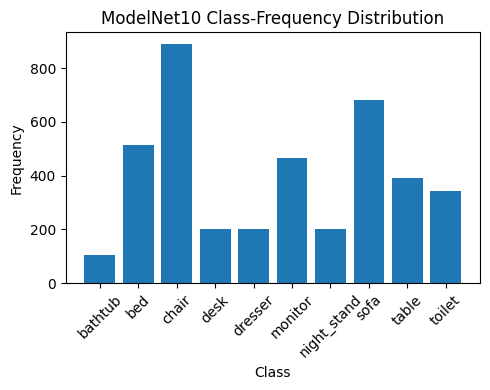

In [ ]:
# Visualize the category distribution in the training dataset

categories = sorted([x.split(os.sep)[-2] for x in glob(os.path.join("ModelNet10", "raw", '*', ''))])
category_dict = {key: 0 for key in categories}
table_data = []

for idx in range(0, len(train_dataset)):
    category_idx = int(train_dataset[idx].y.item())
    category = categories[category_idx]
    category_dict[category] += 1

data = [[key, category_dict[key]] for key in categories]
class_names, frequencies = zip(*data)

plt.figure(figsize=(5, 4))
plt.bar(class_names, frequencies)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("ModelNet10 Class-Frequency Distribution")
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("class_freq.eps", dpi = 300)

#### 2.1.2 Voxelization

In [ ]:
def voxelize(data, voxel_size, c_max=1.25, c_min=-1.25):
    num_voxels = int((c_max - c_min) / voxel_size)

    mesh = o3d.geometry.TriangleMesh()
    vertices, triangles = data.pos.numpy(), data.face.T.numpy()
    mesh.vertices, mesh.triangles = o3d.utility.Vector3dVector(vertices), o3d.utility.Vector3iVector(triangles)
    raw_grids = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size)

    grid_indices = np.asarray([voxel.grid_index for voxel in raw_grids.get_voxels()], dtype=int)
    grid_indices += np.array((num_voxels - grid_indices.max(axis=0))/2, dtype=int)

    voxel_grid = np.zeros((num_voxels, num_voxels, num_voxels), dtype=int)
    voxel_grid[grid_indices[:, 0], grid_indices[:, 1], grid_indices[:, 2]] = 1
    return torch.tensor(voxel_grid)

In [ ]:
voxel_size_list = [0.05, 0.1, 0.2]

train_voxels = []
for voxel_size in voxel_size_list:
    voxels = []
    for i in range(len(train_dataset)):
        voxels.append(voxelize(train_dataset[i], voxel_size))
    train_voxels.append(torch.stack(voxels, dim=0))

test_voxels = []
for voxel_size in voxel_size_list:
    voxels = []
    for i in range(len(test_dataset)):
        voxels.append(voxelize(test_dataset[i], voxel_size))
    test_voxels.append(torch.stack(voxels, dim=0))

Shape index: 716
Object category: chair
Grid number of voxel size 0.05: 50
Grid number of voxel size 0.1: 25
Grid number of voxel size 0.2: 12


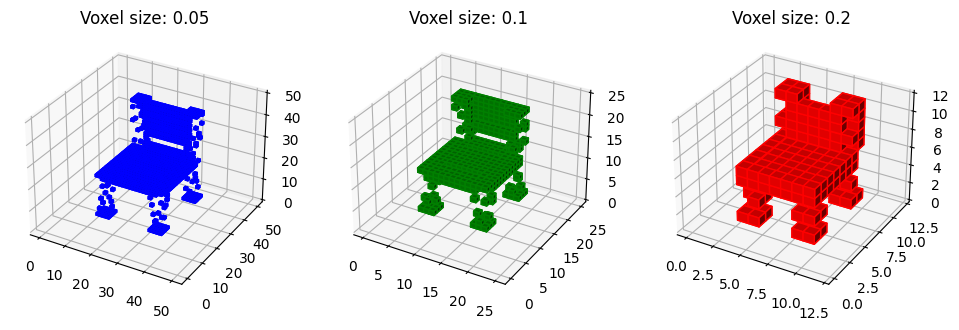

In [ ]:
# Choose an object for visualization
visualize_idx = 716
print("Shape index: {}".format(visualize_idx))
print("Object category: {}".format(categories[train_dataset[visualize_idx].y.item()]))
print("Grid number of voxel size {}: {}".format(voxel_size_list[0], train_voxels[0].shape[-1]))
print("Grid number of voxel size {}: {}".format(voxel_size_list[1], train_voxels[1].shape[-1]))
print("Grid number of voxel size {}: {}".format(voxel_size_list[2], train_voxels[2].shape[-1]))

fig = plt.figure(figsize=(16,24))
ax0 = fig.add_subplot(141, projection='3d')
ax1 = fig.add_subplot(142, projection='3d')
ax2 = fig.add_subplot(143, projection='3d')

# Create the voxel visualization
ax0.voxels(train_voxels[0][visualize_idx].numpy(), facecolors='blue', edgecolor='blue')
ax1.voxels(train_voxels[1][visualize_idx].numpy(), facecolors='green', edgecolor='green')
ax2.voxels(train_voxels[2][visualize_idx].numpy(), facecolors='red', edgecolor='red')

# Set labels for the axes
ax0.set_title("Voxel size: {}".format(voxel_size_list[0]))
ax1.set_title("Voxel size: {}".format(voxel_size_list[1]))
ax2.set_title("Voxel size: {}".format(voxel_size_list[2]))

# Show the plot
plt.savefig("visualization_voxel.eps", dpi = 300, bbox_inches='tight')

#### 2.1.3 CNN

*a. Dataset*

In [ ]:
class VoxelDataset(Dataset):
    def __init__(self, voxels, labels):
        self.voxels = voxels[:, None, :, :, :].to(dtype=torch.float)
        self.labels = labels.to(dtype=torch.long)

    def __len__(self):
        return len(self.voxels)

    def __getitem__(self, idx):
        voxel = self.voxels[idx]
        label = self.labels[idx]
        return voxel, label

*b. Model*

In [ ]:
class VoxelCNN(nn.Module):
    def __init__(self, num_classes, voxel_size_choice):
        super(VoxelCNN, self).__init__()

        if voxel_size_choice == 0:
            self.conv1 = nn.Conv3d(in_channels=1, out_channels=48, kernel_size=8, stride=3) # 50 -> 15
            self.conv2 = nn.Conv3d(in_channels=48, out_channels=160, kernel_size=7, stride=2) # 15 -> 5
            self.conv3 = nn.Conv3d(in_channels=160, out_channels=512, kernel_size=4, stride=1) # 5 -> 2

        elif voxel_size_choice == 1:
            self.conv1 = nn.Conv3d(in_channels=1, out_channels=48, kernel_size=5, stride=2) # 25 -> 11
            self.conv2 = nn.Conv3d(in_channels=48, out_channels=160, kernel_size=5, stride=2) # 11 -> 4
            self.conv3 = nn.Conv3d(in_channels=160, out_channels=512, kernel_size=3, stride=1) # 4 -> 2

        elif voxel_size_choice == 2:
            self.conv1 = nn.Conv3d(in_channels=1, out_channels=48, kernel_size=2, stride=2) # 12 -> 6
            self.conv2 = nn.Conv3d(in_channels=48, out_channels=160, kernel_size=2, stride=2) # 6 -> 3
            self.conv3 = nn.Conv3d(in_channels=160, out_channels=512, kernel_size=2, stride=1) # 3 -> 2

        self.fc1 = nn.Linear(4096, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    @torch.no_grad()
    def eval_accuracy(self, evalloader):
        correct = 0
        total = 0
        for idx, (voxel, label) in enumerate(evalloader):
            voxel, label = voxel.to("cuda"), label.to("cuda")
            pred = self(voxel).max(dim=1)[1]
            correct += pred.eq(label).sum().item()
            total += label.shape[0]
        return correct / total

*c. Training*

In [ ]:
def use_cnn(seed, voxel_size_choice):
    # seed
    torch.manual_seed(seed)

    # dataset and dataloader
    train_dataset_voxel = VoxelDataset(train_voxels[voxel_size_choice], train_dataset.y)
    test_dataset_voxel = VoxelDataset(test_voxels[voxel_size_choice], test_dataset.y)
    train_loader_voxel = DataLoader(train_dataset_voxel, batch_size=128, shuffle=True)
    test_loader_voxel = DataLoader(test_dataset_voxel, batch_size=16, shuffle=False)

    # model and optimizer
    cnn_model = VoxelCNN(train_dataset.num_classes, voxel_size_choice).to("cuda")
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=5e-5)

    # train
    best_test_acc = 0
    for epoch in range(15):
        cnn_model.train()

        for idx, (voxel, label) in enumerate(train_loader_voxel):
            voxel, label = voxel.to("cuda"), label.to("cuda")
            pred = cnn_model(voxel)
            loss = F.cross_entropy(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # valid
        if (epoch + 1) % 1 == 0:
            cnn_model.eval()
            valid_acc = cnn_model.eval_accuracy(test_loader_voxel)
            print("Epoch: {}\tValidation accuracy: {}".format(epoch + 1, valid_acc))

            if valid_acc > best_test_acc:
                best_test_acc = valid_acc

    # test
    return best_test_acc

seed = 114514
voxel_size_choice_list = [0, 1, 2]
accuracies = []
for i in range(len(voxel_size_choice_list)):
    print("### Voxel size: {}".format(voxel_size_list[i]))
    test_acc = use_cnn(seed, voxel_size_choice_list[i])
    print("Test accuracy: {}\n".format(test_acc))
    accuracies.append(test_acc)

### Voxel size: 0.05
Epoch: 1	Validation accuracy: 0.43612334801762115
Epoch: 2	Validation accuracy: 0.7687224669603524
Epoch: 3	Validation accuracy: 0.8149779735682819
Epoch: 4	Validation accuracy: 0.8689427312775331
Epoch: 5	Validation accuracy: 0.8887665198237885
Epoch: 6	Validation accuracy: 0.8964757709251101
Epoch: 7	Validation accuracy: 0.8843612334801763
Epoch: 8	Validation accuracy: 0.8557268722466961
Epoch: 9	Validation accuracy: 0.8843612334801763
Epoch: 10	Validation accuracy: 0.8865638766519823
Epoch: 11	Validation accuracy: 0.8766519823788547
Epoch: 12	Validation accuracy: 0.8766519823788547
Epoch: 13	Validation accuracy: 0.8722466960352423
Epoch: 14	Validation accuracy: 0.8920704845814978
Epoch: 15	Validation accuracy: 0.8821585903083701
Test accuracy: 0.8964757709251101

### Voxel size: 0.1
Epoch: 1	Validation accuracy: 0.7918502202643172
Epoch: 2	Validation accuracy: 0.8524229074889867
Epoch: 3	Validation accuracy: 0.8689427312775331
Epoch: 4	Validation accuracy: 0.874

Plot acc. vs. voxel size

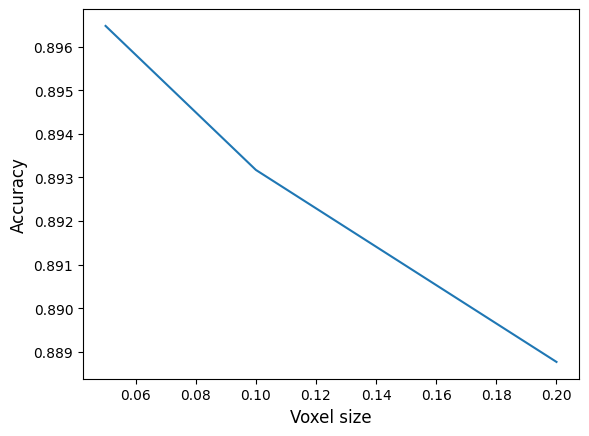

In [ ]:
plt.plot(voxel_size_list, accuracies)
plt.xlabel("Voxel size", fontsize = 12)
plt.ylabel("Accuracy", fontsize = 12)
plt.savefig("acc_voxel.eps", dpi = 300, bbox_inches='tight')